## Getting the dataset:

In [13]:
!mkdir data
%cd data

/content/data


In [20]:
import requests
import bs4
path = 'https://gimms.gsfc.nasa.gov/SMOS/SMAP/L03/'
r = requests.get(path)
soup = bs4.BeautifulSoup(r.text, 'html.parser')

links = soup.find_all('a')
print("Found total {} links".format(len(links)))

Found total 1295 links


In [21]:
import sys
print("Downloading data.....")
l = len(links)
for i,link in enumerate(links):
  sys.stdout.write('\r{:.2f} % complete          '.format(i/l*100))
  if link['href'].endswith('.as1.grib'):
    file_ = requests.get(path+link['href'])
    with open(link['href'], 'wb') as f:
      f.write(file_.content)
  else:
    pass
sys.stdout.write('\r100 % complete       \n')
print("Done")

100 % complete       
Done


## Starting with the EDA:

In [24]:
import pygrib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
%matplotlib inline
plt.figure(figsize=(20,12))

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

In [26]:
grbs = pygrib.open('data/20150402_20150404.as1.grib')

In [28]:
grb_1 = grbs.select()[0]
grb_1.values.shape

(600, 1440)

In [29]:
print(len(grb_1.keys()))
print(grb_1.keys())

176
['globalDomain', 'GRIBEditionNumber', 'eps', 'offsetSection0', 'section0Length', 'totalLength', 'editionNumber', 'WMO', 'productionStatusOfProcessedData', 'section1Length', 'wrongPadding', 'table2Version', 'centre', 'centreDescription', 'generatingProcessIdentifier', 'gridDefinition', 'indicatorOfParameter', 'parameterName', 'parameterUnits', 'indicatorOfTypeOfLevel', 'pressureUnits', 'typeOfLevelECMF', 'typeOfLevel', 'level', 'yearOfCentury', 'month', 'day', 'hour', 'minute', 'second', 'unitOfTimeRange', 'P1', 'P2', 'timeRangeIndicator', 'numberIncludedInAverage', 'numberMissingFromAveragesOrAccumulations', 'centuryOfReferenceTimeOfData', 'subCentre', 'paramIdECMF', 'paramId', 'cfNameECMF', 'cfName', 'cfVarNameECMF', 'cfVarName', 'unitsECMF', 'units', 'nameECMF', 'name', 'decimalScaleFactor', 'setLocalDefinition', 'optimizeScaleFactor', 'dataDate', 'year', 'dataTime', 'julianDay', 'stepUnits', 'stepType', 'stepRange', 'startStep', 'endStep', 'marsParam', 'validityDate', 'validityT

In [30]:
len(grbs.select())

1

In [31]:
grb_0 = grbs.select()[0]
print("Name of the parameter: {}".format(grb_0['name']))
print("Maximum Value: {}".format(grb_0['maximum']))
print("Minimum Value: {}".format(grb_0['minimum']))
print("Average Value: {}".format(grb_0['average']))
print("Standard Deviation Value: {}".format(grb_0['standardDeviation']))
print("Date (d/M/Y): {}/{}/{}".format(grb_0['day'],grb_0['month'],grb_0['yearOfCentury']))

Name of the parameter: unknown
Maximum Value: 25.400115200000005
Minimum Value: 0.0
Average Value: 13.486237524703515
Standard Deviation Value: 9.069189779525063
Date (d/M/Y): 2/4/15


## Plotting the data:

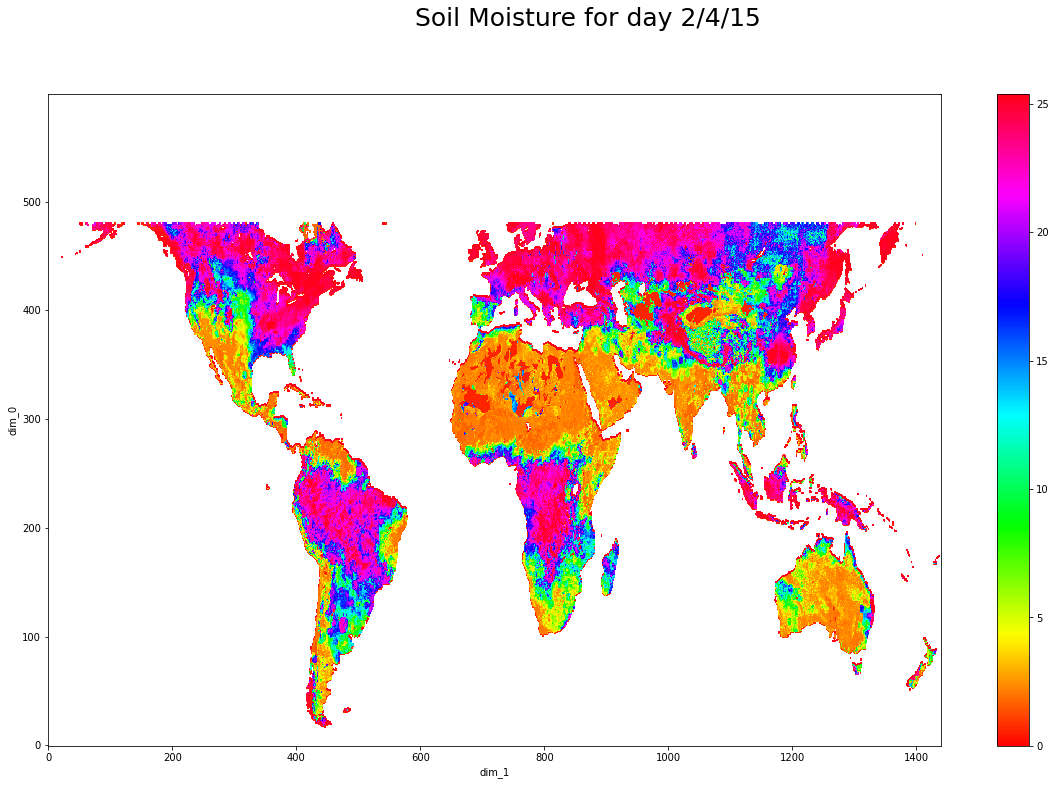

In [36]:
data = xr.DataArray(grb_0.values)
plt.figure(figsize=(20,12)).suptitle('Soil Moisture for day 2/4/15', ha='center', fontsize=25)
data.plot(cmap='hsv')

## Plotting the statistics of the daily data:

In [54]:
dates = []
means = []
mins = []
maxs = []
vars = []
errors = 0
print("Calculating statistics....")
l = os.listdir('data')
length = len(l)
for i, file_ in enumerate(l):
  sys.stdout.write('\r {:.2f} % complete    '.format(i/length*100))
  try:
    grb = pygrib.open('data/'+file_).select()[0]
    dates.append(str(grb['day'])+'-'+str(grb['month'])+'-'+str(grb['yearOfCentury']))
    means.append(grb['average'])
    mins.append(grb['minimum'])
    maxs.append(grb['maximum'])
    vars.append(grb['standardDeviation']**2)
  except ValueError:
    print("Error for file {}".format(file_))
    errors+=1
    pass
print('\r 100 % complete       \n')
print("Done calculating the statistics")
print("Encountered {} errors".format(errors))

Calculating statistics....
 49.85 % complete    Error for file .ipynb_checkpoints
 100 % complete       

Done calculating the statistics
Encountered 1 errors


645


<BarContainer object of 645 artists>

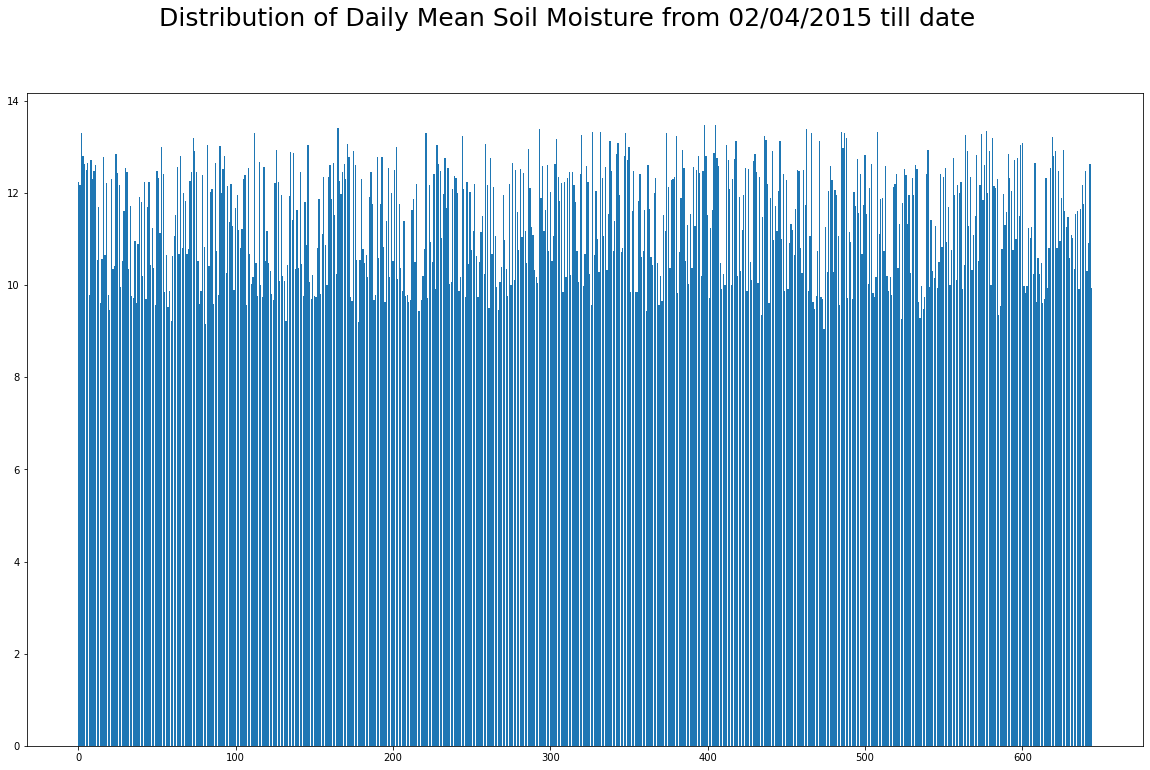

In [50]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Mean Soil Moisture from 02/04/2015 till date', ha='center', fontsize=25)
plt.bar(np.arange(len(means)), means)

<BarContainer object of 645 artists>

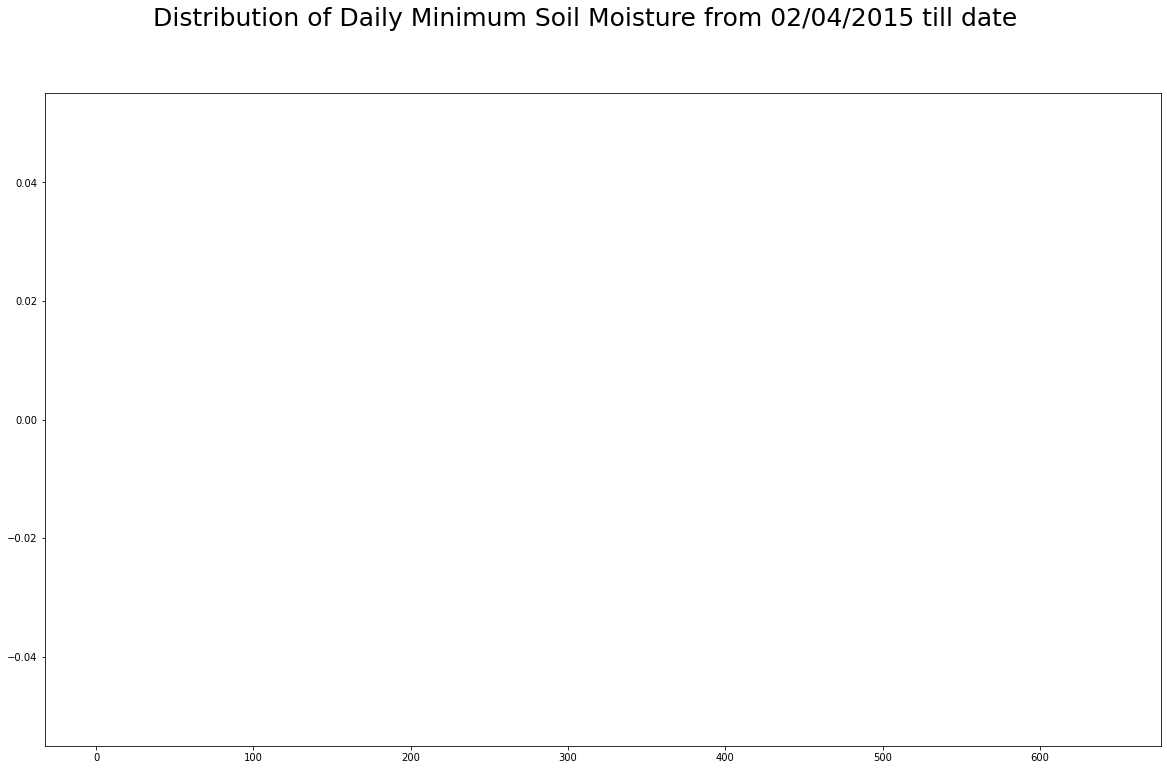

In [51]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Minimum Soil Moisture from 02/04/2015 till date', ha='center', fontsize=25)
plt.bar(np.arange(len(mins)), mins)

<BarContainer object of 645 artists>

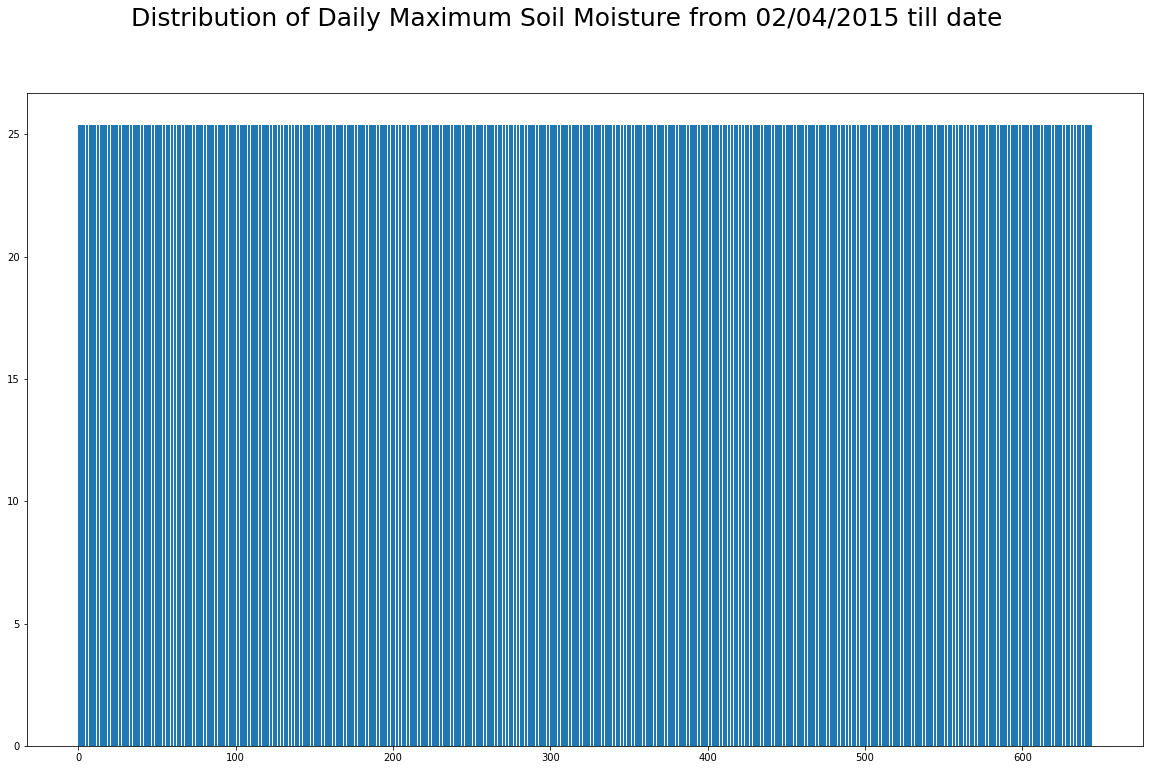

In [52]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Maximum Soil Moisture from 02/04/2015 till date', ha='center', fontsize=25)
plt.bar(np.arange(len(maxs)), maxs)

<BarContainer object of 645 artists>

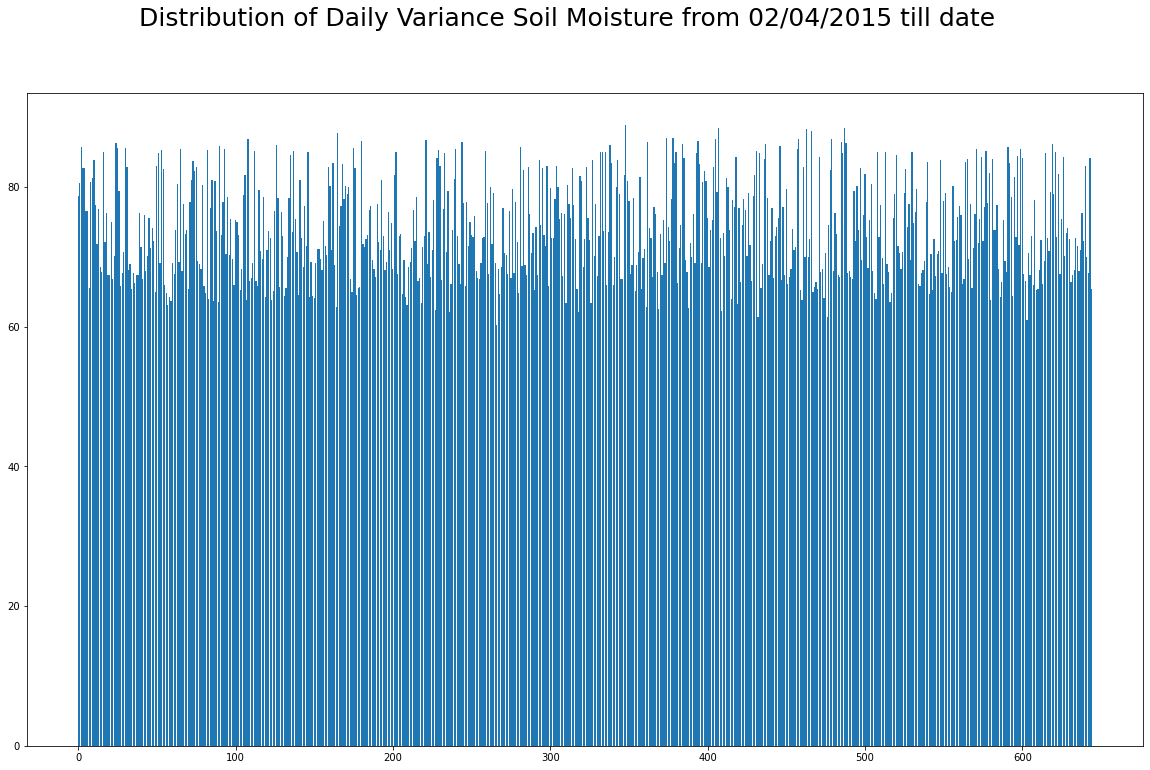

In [53]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Variance Soil Moisture from 02/04/2015 till date', ha='center', fontsize=25)
plt.bar(np.arange(len(vars)), vars)

## Summary:
Thus, from the above preliminary EDA of the soil moisture data, it seems that the distribution of the soil moisture around the year is fairly consistent as both the mean and variance distribution has similar shape

In [55]:
import pandas as pd
data = pd.DataFrame({'Date':dates, 'Mean Soil Moisture': means, 'Minimum Soil Moisture': mins, 'Maximum Soil Moisture':maxs, 'Variance of Soil Moistures': vars})
data.to_csv('Analysis_of_Soil_Moisture.csv', index=False)